# Development platform for SPICE-based orbit propagator

2019/11/07

### Developed with problem for GTOC4 in mind:
- allow mutliple bodies to be propagated at the same time (e.g. multiple asteroids and spacecraft)
- compute relative distance between specified bodies during propagation)

In [1]:
import numpy as np
import spiceypy as spice
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

In [2]:
# load spice kernels
spice.furnsh('../spice/naif0012.tls')

# define gravitational parameters
MU = 1.32712440018*10**11      # sun's gravitational parameter [km^3/s^2]
au2km = 1.49597870691*10**8    # 1 astronomical unit [AU] to [km]
g0 = 9.80665                   # gravitational acceleration [m/s^2]


In [3]:
# import ephemerides data from GTOC4 into pandas dataframe
elmnts = ['Name','Epoch','a','e','i','LAN','periap','theta']
df = pd.read_fwf('../gtoc4_problem_data.txt', sep='\t', skiprows=1)
# reassign column names
df.columns =  ['Name','Epoch','a','e','i','LAN','omega','M0']
num,tmp = df.shape
print(df.shape)
df.head(3)

(1436, 8)


,Name,Epoch,a,e,i,LAN,omega,M0
0,'1580',54800.0,2.196803,0.487683,52.090794,62.324795,159.539839,3.521687
1,'1620',54800.0,1.245551,0.335511,13.337693,337.266017,276.806539,136.950031
2,'1943',54800.0,1.430317,0.255816,8.704065,246.401915,338.253875,288.405238


In [11]:
# create smaller pandas dataframe to test propagator
# FIXME : create here spacecraft dataframe, then merge?
#  df1.merge(df2, left_on='lkey', right_on='rkey')
el_pd1 = df[0:10]
el_pd1.shape

(10, 8)

In [12]:
# conversion between MJD and JD
# (Data given in MJD, SPICE deals with JD)
def _mjd2jd(mjd):
    """function converts MJD (Modified Julian Date) to JD (Julian Date)
    Args:
        mjd (float or lst): float or list of floats of ephemerides in MJD to be converted to JD
    Returns:
        (float or float): float or list of ephemeris equivalent in JD
    """
    if type(mjd) == list: 
        jd = [el + 2400000.5 for el in mjd]
    else:
        jd = mjd + 2400000.5
    return jd

def _jd2mjd(jd):
    """function converts JD (Julian Date) to MJD (Modified Julian Date)
    Args:
        mjd (float or lst): float or list of floats of ephemerides in JD to be converted to MJD
    Returns:
        (float or float): float or list of ephemeris equivalent in MJD
    """
    if type(mjd) == list: 
        mjd = [el - 2400000.5 for el in jd]
    else:
        mjd = jd - 2400000.5
    return mjd


In [13]:
# propagator ... could also make a separate function just to compute dr? or an option?
def propagate_spice(etr_mjd, eldf, MU=1.32712440018*10**11, step=1000):
    """
    SPICE-powered orbit propagator developed for GTOC4
    Args:
        et_MJD (lst): list including start and end time of propagation (in MJD)
        step (float): steps of propagation
        eldf (pandas df): pandas dataframe of orbital elements to be propagated (expect spacecraft to be first row)
    Returns:
        (tuple): state-vector, dr
    """
    
    # convert time range from MJD to JD
    etr_jd = _mjd2jd((etr_mjd))
    # create time array
    etrsteps = [x * (etr_jd[1] - etr_jd[0])/step + etr_jd[0] for x in range(step)]
    # store number of bodies to propagate
    [bdy,tmp] = eldf.shape
    # initialize 3d numpy array to store state-vectors
        # first:  number of arrays = number of bodies to propagate
        # second: rows = timesteps
        # third:  columns = x, y, z, vx, vy, vz
    sv = np.zeros((bdy, step, 6))
    
    # propagate over time array
    for i in range(step):
        # prepare orbital elements for spice.conics() function
        for j in range(bdy):
            # convert orbital elements to spice-format
            rp = eldf.at[j,'a']*au2km * (1 - eldf.at[j,'e'])
            elts = np.array([rp, eldf.at[j,'e'], np.rad2deg(eldf.at[j,'i']), np.rad2deg(eldf.at[j,'LAN']), np.rad2deg(eldf.at[j,'omega']), np.rad2deg(eldf.at[j,'M0']), _mjd2jd(eldf.at[j,'Epoch']), MU])
            tmp = spice.conics(elts, etrsteps[i])
            
            # FIXME - store state-vector of one object into sv 3d numpy array
            for k in range(6):
                sv[(j,i,k)] = tmp[k]
        
        #state = spice.conics(elts, etrsteps[i])
    
    return sv
    

In [14]:
# test run function with el_pd1
# propagation range time
etr_utc = ['Jan 1, 2015', 'Jun 30, 2025']  # currently working with 6 months ~ 182 days
etr_MJD = [spice.str2et(etr_utc[0]), spice.str2et(etr_utc[1])]
# set time-step in seconds
steps = 1000
dt = (spice.str2et(etr_utc[1]) - spice.str2et(etr_utc[0]))/steps
dt_day = dt/(60*60*24)
print(f'Current time-interval size with {steps} steps : {dt_day:.4} [days]')

# call function to propagate
sv = propagate_spice(etr_MJD, el_pd1, MU=1.32712440018*10**11, step=steps)

sv[(0,2,0)]

Current time-interval size with 1000 steps : 3.833 [days]


33290994.736695647

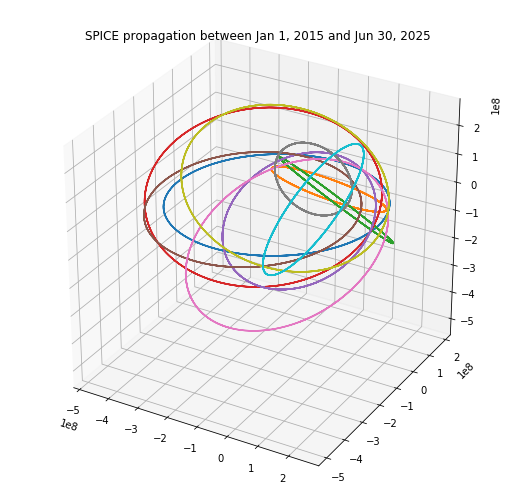

In [15]:
# plot propagated trajectories
fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection = '3d')

# store number of bodies to propagate
[bdy,tmp] = el_pd1.shape
# store number of time steps
[tmp,steps,tmp] = sv.shape

# FIXME - ploting...? make a function?
for i in range(bdy):
    tmpx = []
    tmpy = []
    tmpz = []
    for j in range(steps):
        tmpx.append(sv[(i,j,0)])
        tmpy.append(sv[(i,j,1)])
        tmpz.append(sv[(i,j,2)])
    ax.plot(tmpx,tmpy,tmpz)

        # first:  number of arrays = number of bodies to propagate
        # second: rows = timesteps
        # third:  columns = x, y, z, vx, vy, vz
    
#ax.plot(sv_prop_Earth[0], sv_prop_Earth[1], sv_prop_Earth[2])

plt.title(f'SPICE propagation between {etr_utc[0]} and {etr_utc[1]}')
plt.show()